In [289]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

In [296]:
class Environment:
    def __init__(self, noise=0, friction=0):
        self.n_actions = 3
        self.n_obs = 3
        self.max_steps = 100
        self.shape = (3,10)
        self.noise = noise
        self.friction = friction
        
    def reset(self):
        self.x = self.shape[1]
        self.state = []
        self.allocation = np.zeros(shape=(3,))
        self.allocation[0] = 1
        self.episode_rewards = [0]
        self.previous_allocation = self.allocation
        
        self.x_space = np.arange(self.max_steps)
        a0_space = np.zeros_like(np.linspace(0,1,self.max_steps))
        self.state.append(a0_space)
        current = [a0_space[self.x-self.shape[1]:self.x]]
        for i in range(1, self.shape[0]):
            a_c = np.random.randint(2,17)
            a_space = np.sin(np.linspace(0,a_c*np.pi,self.max_steps))
            a_space += np.random.normal(0, self.noise, size=a_space.shape)
            self.state.append(a_space)
            current.append(a_space[self.x-self.shape[1]:self.x])
            
        return np.array(current)
    
    def step(self, allocation):
        self.allocation = allocation
        self.x += 1
        current = []
        reward = []
        for i in range(self.shape[0]):
            a_space = self.state[i][self.x-self.shape[1]:self.x]
            current.append(a_space)
            reward.append(a_space[-1]*allocation[i])
        
        cost = self.friction*abs(self.previous_allocation - allocation)
        reward -= cost
        self.previous_allocation = self.allocation
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        self.episode_rewards.append(np.sum(reward))
        return np.array(current), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.a0_data, self.a1_data, self.a2_data, self.allocation
    
    def render(self):
        #x_data, a0_data, a1_data, a2_data, alloc_data = self.get_render_data()
        fig, ax = plt.subplots(1,3,figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1,1]})

        for i in range(self.shape[0]):
            a_space = self.state[i]
            ax[0].plot(self.x_space, a_space, label=str(i))
            
        ax[0].legend(loc='upper left')
        ax[0].plot([self.x, self.x], [-0.1,0.1], 'k')
        ax[1].set_ylim(0,1)
        ax[1].bar([0,1,2], self.allocation)
        ax[2].plot(self.episode_rewards)

        plt.show()

s0 (3, 10)
s [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.97400534  1.21160696  0.66331215 -0.06204618  0.85944796  0.35645435
   0.15310166 -1.21315156 -0.70484725 -1.39029091]
 [ 0.59597275  0.44364604  0.01210873  0.70316507  0.8797628   0.44925511
   1.07227822  0.92417362  0.20991317  1.08958221]]
r [ 0.         -0.27805818  0.5447911 ]
d False


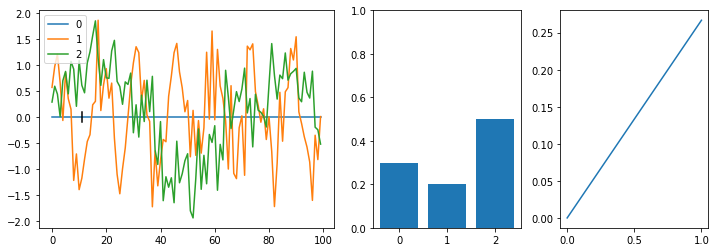

In [297]:
env = Environment(0.5)
s0 = env.reset()
print('s0', s0.shape)
s, r, d, i = env.step(np.array([0.3, 0.2, 0.5]))
print('s',s)
print('r',r)
print('d',d)
env.render()

In [321]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-2, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        K.clear_session()
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.obs_shape = None
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.coef = 0.01
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 

        self.DUMMY_ALLOCATION, self.DUMMY_VALUE = np.zeros((1, self.n_actions)), np.zeros((1, self.n_obs))

    def proximal_policy_optimization_loss(self, advantage, debug=True):
        def loss(y_true, y_pred):
            y_pred = K.print_tensor(y_pred, 'pred ')
            adv = K.print_tensor(advantage, 'adva ')
            return -self.coef*adv*y_pred + self.entropy_loss*y_pred*K.log(y_pred+1e-10)
        return loss
    
    def build_actor(self):
        state_inputs = Input(shape=(self.n_obs*10,),name='observation')
        advantage = Input(shape=(self.n_obs,),name='advantage')
        previous_allocation = Input(shape=(self.n_actions,),name='previous_allocation')

        x = concatenate([state_inputs, previous_allocation])
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, previous_allocation],
                      outputs=[out_actions])
        
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage
                      )])
        return model

    def get_allocation(self, obs, prev_alloc):
        obs = np.array([obs.flatten()])
        p_al = np.array([prev_alloc])
        alloc = self.actor.predict([obs, self.DUMMY_VALUE, p_al])
        if print_log:
            print('get_allocation')
            print('obs shape:', obs.shape)
            print('DUMMY shape:', self.DUMMY_VALUE.shape)
            print('alloc shape:', alloc.shape)
            print()
        return alloc
    
    def train_batch(self, observations, allocations, rewards, previous_allocations):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        allocs = allocations[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        prev_allocs = previous_allocations[:self.buffer_size]
        
        if print_log:
            print('train_batch:')
            print('obs Shape:', obs.shape)
            print('allocs Shape:', allocs.shape)
            print('rews Shape:', rews.shape)
            print()
        
        self.actor.fit([obs, rews, prev_allocs], [allocs],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False, test_run=False):
        episode = 0
        reward_history = []
        end_test=False
        self.obs_shape = env.shape

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'allocation_vector': [],
                'previous_allocation_vector': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'allocation_vector': [],
                'previous_allocation_vector': [],
                'reward': []
            }
            
            previous_alloc_vector = env.allocation
            tmp_batch['previous_allocation_vector'].append(previous_alloc_vector)

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size and not end_test:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                observation = np.array(observation)
                
                alloc_vector = self.get_allocation(observation, previous_alloc_vector)[0]

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(alloc_vector)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['allocation_vector'].append(alloc_vector)
                tmp_batch['previous_allocation_vector'].append(previous_alloc_vector)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation
                previous_alloc_vector = alloc_vector
                
                if test_run:
                    env.render()

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    # for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                    #     tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        alloc = tmp_batch['allocation_vector'][i]
                        previous_alloc = tmp_batch['previous_allocation_vector'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs.flatten())
                        batch['allocation_vector'].append(alloc)
                        batch['previous_allocation_vector'].append(previous_alloc)
                        batch['reward'].append(r)

                    # every 10th episode, log some stuff
                    if (episode % 100 == 0 or episode == episodes - 1):
                        print('Episode:', episode)
                        print('Reward :', reward_data)
                        print('Average:', np.mean(reward_history[-100:]))
                        print('-'*10)
                        print()
                        env.render()

                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'allocation_vector': [],
                        'previous_allocation_vector': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1
                    
                    if test_run:
                        end_test = True

            if test_run:
                break
                
            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            allocs = np.array(batch['allocation_vector'])
            prev_allocs = np.array(batch['previous_allocation_vector'])
            rewards = np.array(batch['reward'])    
            #rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, allocs, rewards, prev_allocs)
                    
        self.reward_history = reward_history
        return self.reward_history

Episode: 0
Reward : -9.443808993645774
Average: -9.443808993645774
----------



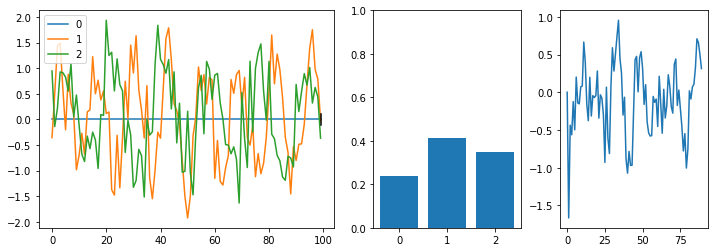

Episode: 100
Reward : -6.157829085567261
Average: -5.250943490977557
----------



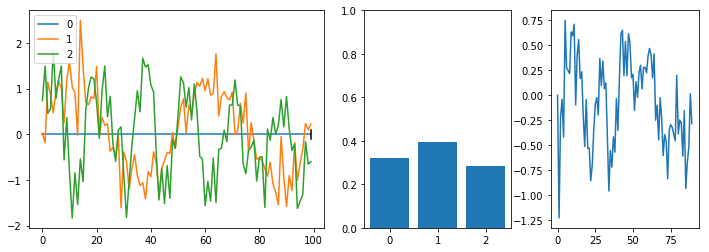

Episode: 200
Reward : -1.1466724699150166
Average: -3.749406388843549
----------



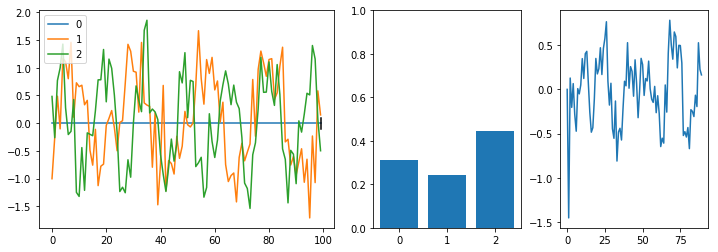

Episode: 300
Reward : -9.72676326987034
Average: -3.8107446135128757
----------



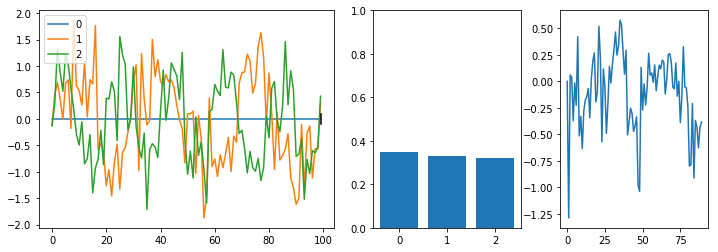

Episode: 400
Reward : 2.6246189978116217
Average: -3.360018640968495
----------



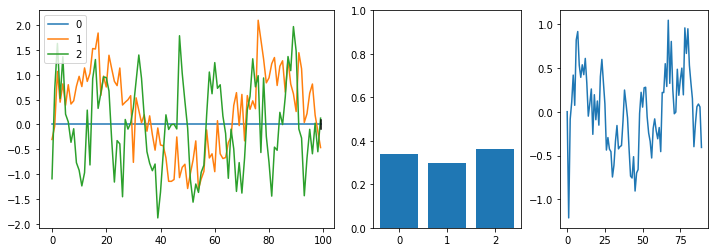

Episode: 500
Reward : -4.400346234150614
Average: -2.9564999980113975
----------



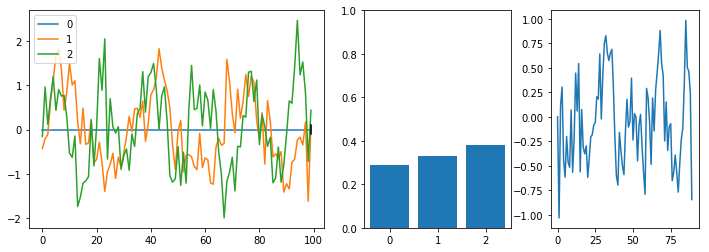

Episode: 600
Reward : -0.6402593180217773
Average: -3.4544698325292105
----------



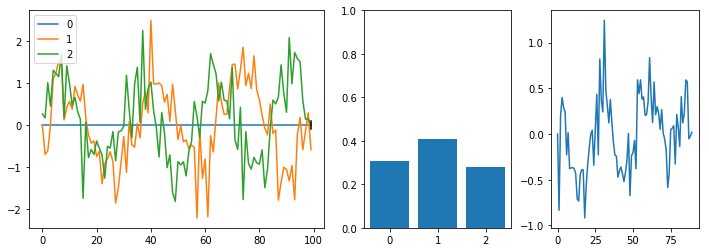

Episode: 700
Reward : 4.975434246140736
Average: -3.5167823177239894
----------



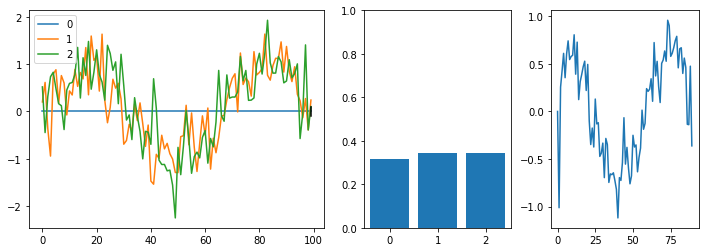

Episode: 800
Reward : 0.7197482396520719
Average: -2.863675604161177
----------



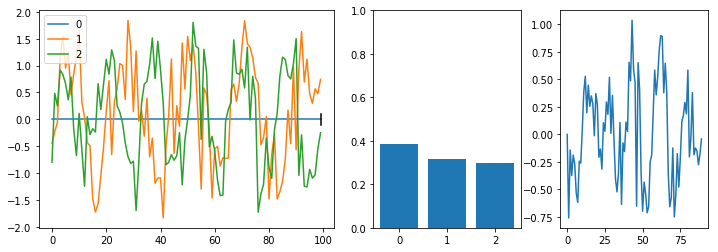

Episode: 900
Reward : -8.309545761043454
Average: -2.5583683426681505
----------



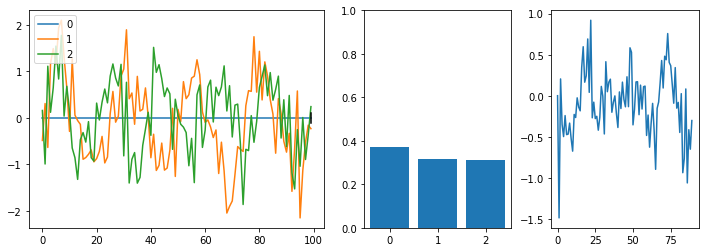

Episode: 1000
Reward : 0.9889963637106516
Average: -2.5452212543582706
----------



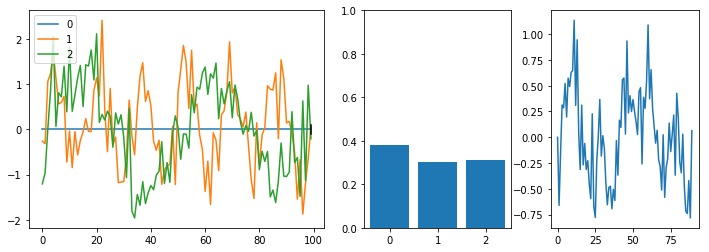

Episode: 1100
Reward : -2.4071133948487953
Average: -2.54449109067279
----------



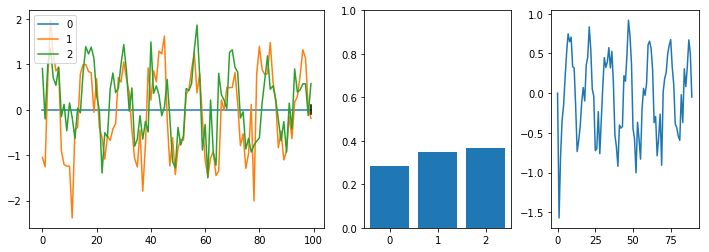

Episode: 1200
Reward : -0.7473523919720365
Average: -2.3803219774758606
----------



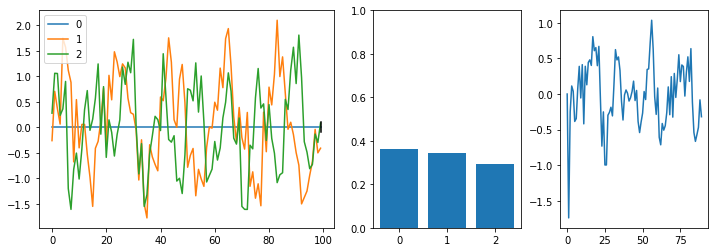

Episode: 1300
Reward : -2.3298302184927207
Average: -2.49495849749681
----------



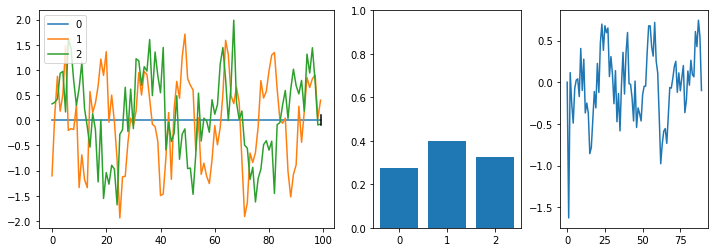

In [ ]:
env = Environment(noise=0.5, friction=1.)
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions
print_log = False

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
rh = agent.run(env, 10000, verbose=False)

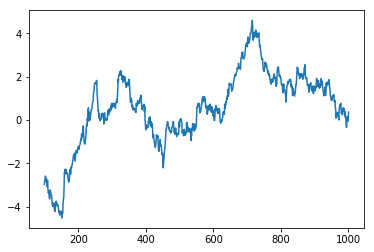

In [319]:
rews = pd.Series(rh).rolling(100).mean()
plt.plot(rews)

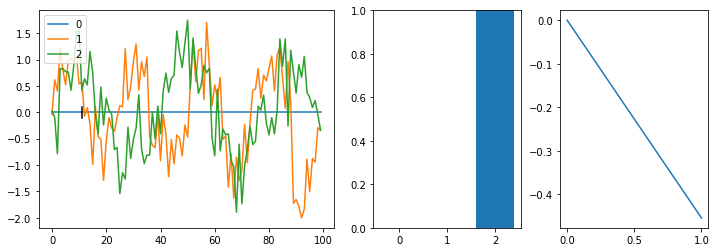

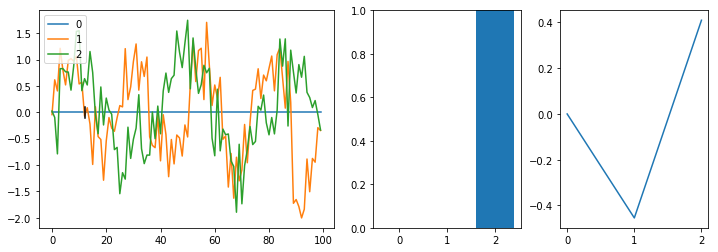

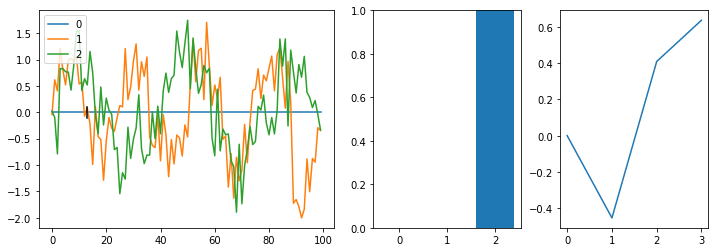

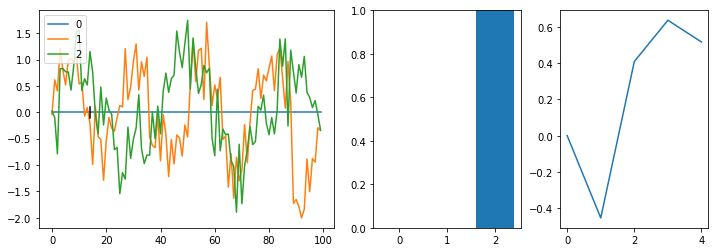

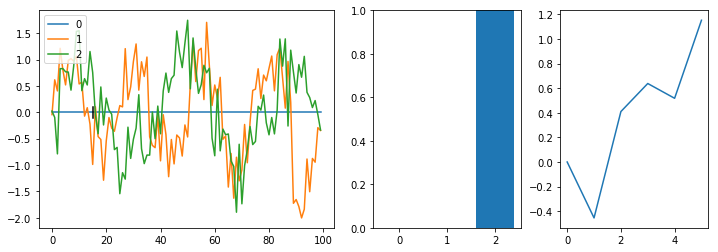

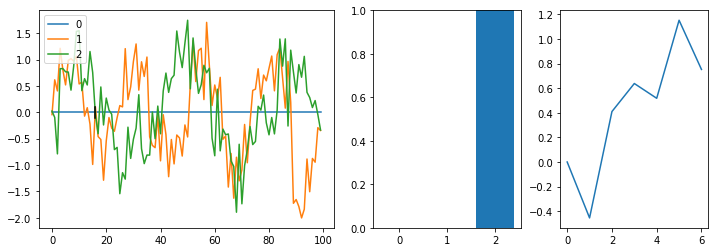

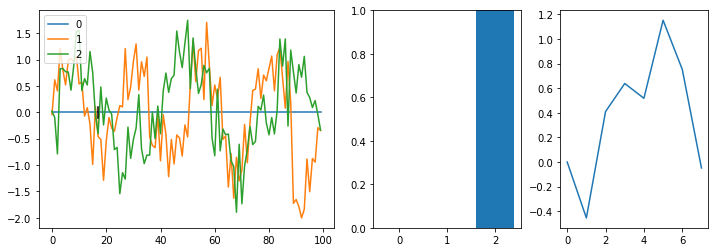

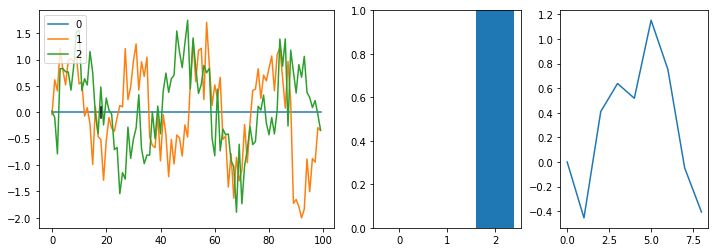

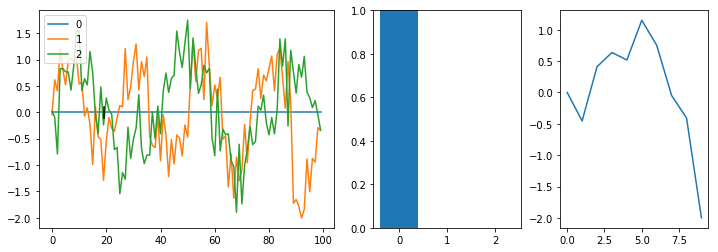

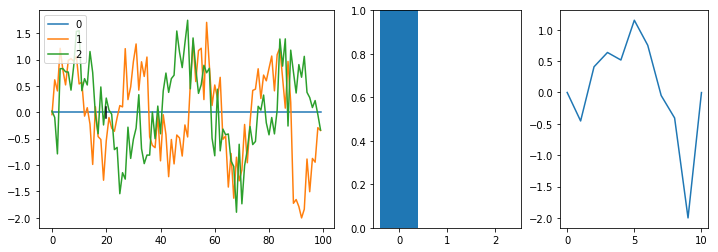

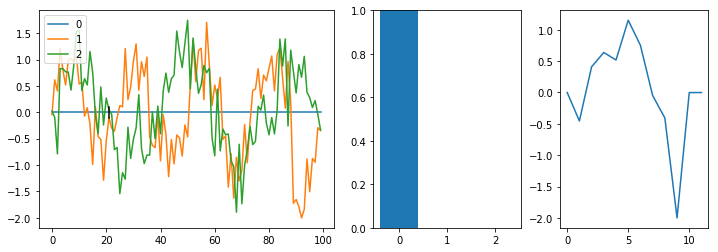

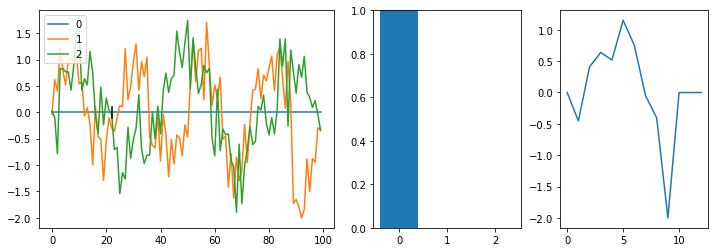

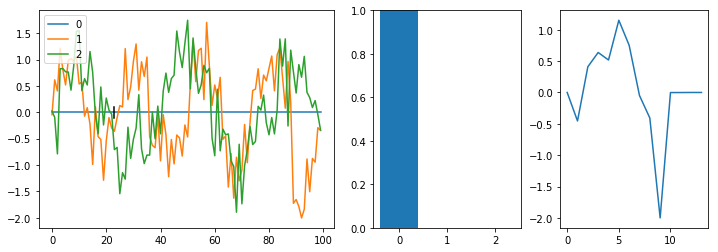

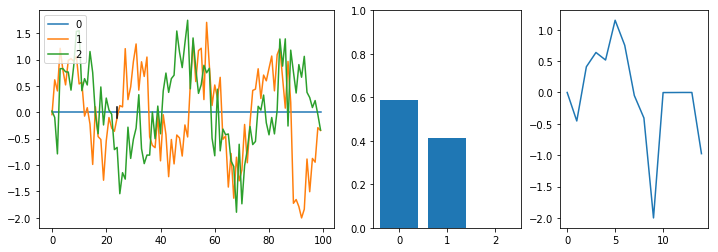

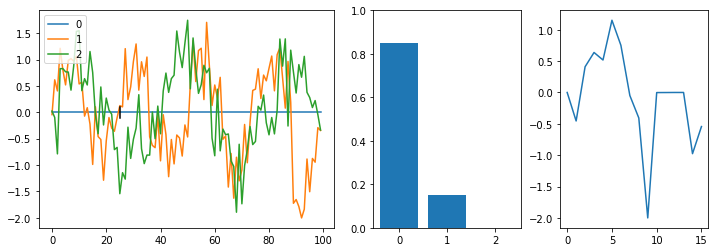

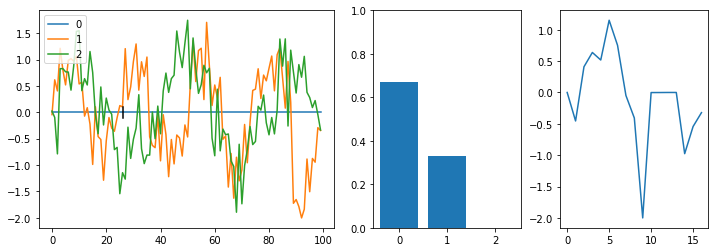

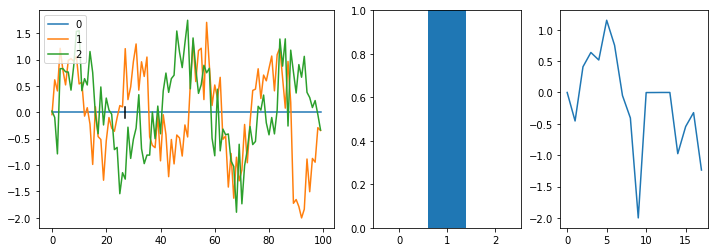

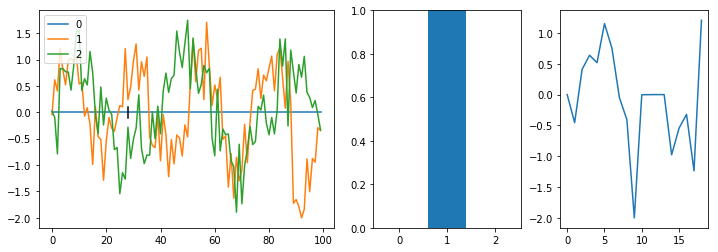

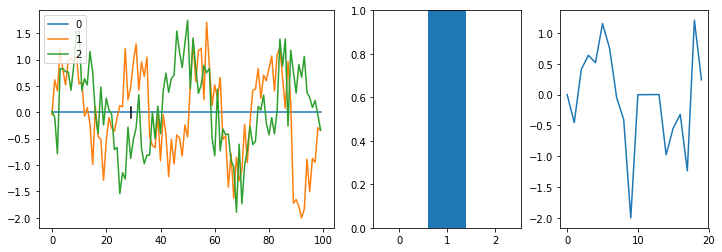

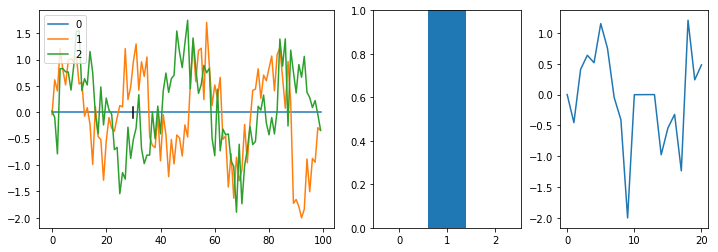

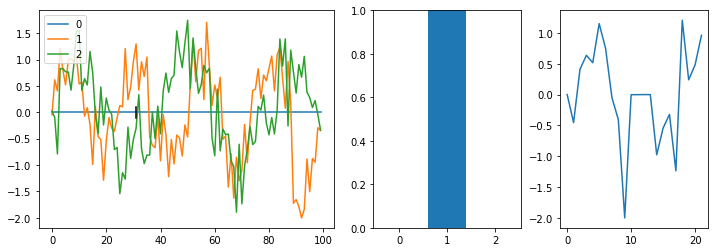

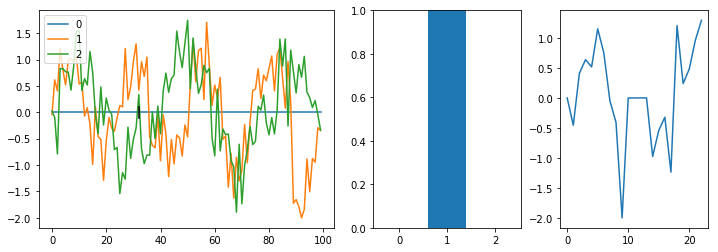

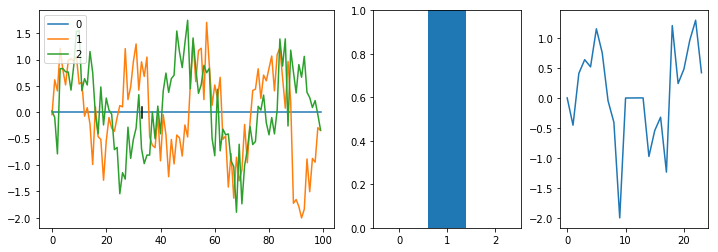

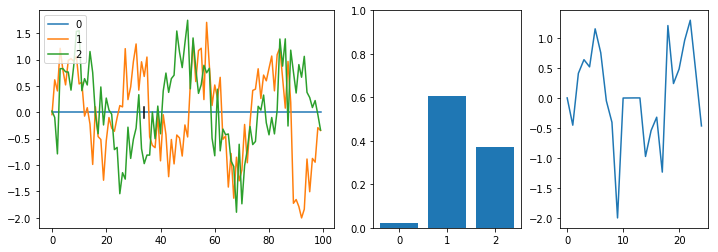

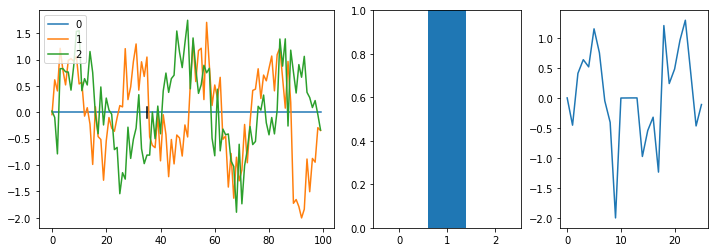

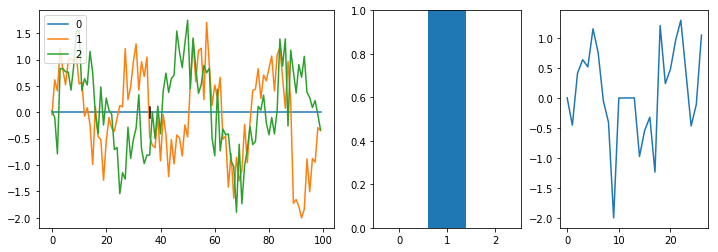

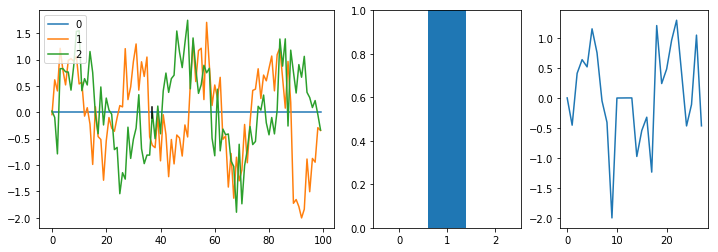

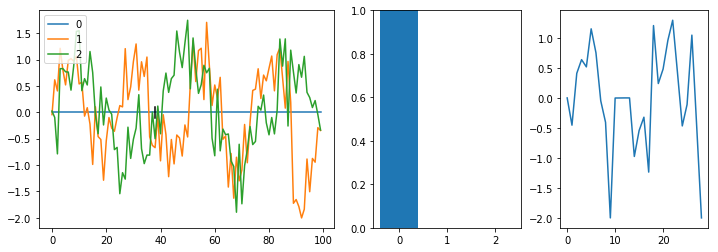

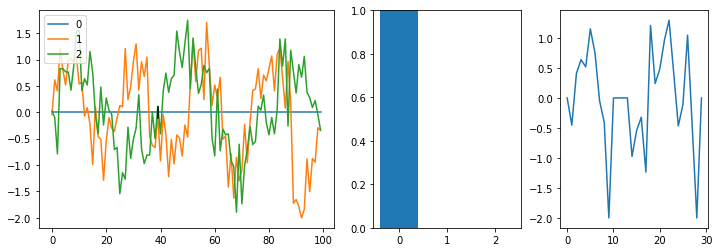

KeyboardInterrupt: 

In [320]:
rh = agent.run(env, 1, test_run=True)